A few references:

* [ARVIZ API](https://python.arviz.org/en/latest/api/index.html)
* [PYMC API](https://www.pymc.io/projects/docs/en/stable/api.html)
* [xarray API](https://docs.xarray.dev/en/stable/api.html)
* [daft](https://docs.daft-pgm.org/en/latest/): &nbsp; [daft & complete pooling](https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer#41_complete_pooling_model)
* [graphviz](https://graphviz.readthedocs.io/en/stable/api.html): &nbsp; [pymc.model_to_graphviz](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.model_to_graphviz.html), <a href="https://www.pymc.io/projects/docs/en/stable/_modules/pymc/model_graph.html#:~:text=VarName%22%2C%20str)%0A%0A%0Aclass-,ModelGraph,-%3A%0A%20%20%20%20def%20__init__(self"> pymc.model_graph.ModelGraph</a>

<br>

# Preliminaries

In [1]:
!python --version

Python 3.8.13


<br>

## Environment

In [2]:
import os
import pathlib

<br>

Set path

In [3]:
os.chdir(path=str(pathlib.Path(os.getcwd()).parent))
os.getcwd()

'J:\\library\\plausibilities\\delineating'

<br>

## Libraries

In [4]:
%matplotlib inline

In [5]:
import logging
import collections

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import pandas as pd
import seaborn as sns

import arviz as az
import pymc as pm
import xarray as xr
import aesara.tensor as at
import graphviz

<br>

Versions

In [6]:
az.__version__

'0.13.0'

In [7]:
pm.__version__

'4.3.0'

In [8]:
np.__version__

'1.22.3'

<br>

## Custom

In [9]:
import src.graphics.settings
import src.graphics.sketch
import src.graphics.models

import src.data.radioactivity
import src.data.features
import src.data.coordinates

import src.models.complete
import src.models.individual
import src.models.unpooled
import src.models.partial
import src.models.vi

import src.models.inference
import src.models.mapping


<br>

Aesthetics

In [10]:
settings = src.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

For diagrams/figures
* The `Labels` class is for `sketch.annotation(ax, Labels(title='...', xlabel='...', ylabel='...'))`

In [11]:
sketch = src.graphics.sketch.Sketch()
Labels = collections.namedtuple(typename='Labels', field_names=['title', 'xlabel', 'ylabel'])

<br>

For the DAG (directed acyclic graph) of models

In [12]:
path = os.path.join(os.getcwd(), 'notebooks')
dag = src.graphics.models.Models(path=path)

<br>

## Settings

Seed

In [13]:
RANDOM_SEED = 8924

<br>

Graphing

In [14]:
az.style.use('arviz-darkgrid')

<br>

## Logging

In [15]:
logging.basicConfig(level=logging.INFO, 
                    format='\n%(message)s\n%(asctime)s.%(msecs)03d\n', 
                    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>
<br>

# Data

Excerpt: Focusing on Minnesota, MN, dwellings.

In [16]:
excerpt = src.data.radioactivity.Radioactivity().exc(state='MN')
logger.info(excerpt.columns)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm'],
      dtype='object')
2022-12-01 20:33:16.801


# of instances: (919, 27)
2022-12-01 20:33:16.802


# of unique codes: (919,)
2022-12-01 20:33:16.803



<br>

Extra features

In [17]:
excerpt = src.data.features.Features().exc(data=excerpt)
logger.info(excerpt.columns)
logger.info(f'# of instances: {excerpt.shape}')
logger.info(f"# of unique codes: {excerpt['idnum'].unique().shape}")


Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm', 'ln_radon',
       'countyindex'],
      dtype='object')
2022-12-01 20:33:16.845


# of instances: (919, 29)
2022-12-01 20:33:16.846


# of unique codes: (919,)
2022-12-01 20:33:16.848



<br>

Frequencies

In [18]:
frequencies = excerpt[['county', 'countyindex', 'floor']].groupby(by=['county', 'countyindex', 'floor'], sort=False).value_counts()
frequencies.rename('N', inplace=True)
frequencies = frequencies.to_frame()
frequencies.reset_index(drop=False, inplace=True)
logger.info(frequencies.head())


   county  countyindex  floor   N
0  AITKIN            0      0   3
1  AITKIN            0      1   1
2   ANOKA            1      0  49
3   ANOKA            1      1   3
4  BECKER            2      0   1
2022-12-01 20:33:16.871



<br>
<br>

# Exploratory Graphs

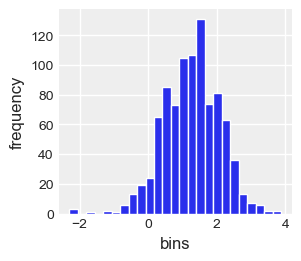

In [19]:
ax = sketch.figure(width=2.9, height=2.5)
ax.hist(excerpt.ln_radon, bins=25)
sketch.annotation(ax, Labels(title='', xlabel='bins', ylabel='frequency'))

<br>
<br>

# Models

The model's initial co$\ddot{o}$rdinates

In [20]:
coords = src.data.coordinates.Coordinates(data=excerpt).exc()
logger.info(coords)


{'Level': {'Basement': 0, 'Ground': 1}, 'County': {'AITKIN': 0, 'ANOKA': 1, 'BECKER': 2, 'BELTRAMI': 3, 'BENTON': 4, 'BIG STONE': 5, 'BLUE EARTH': 6, 'BROWN': 7, 'CARLTON': 8, 'CARVER': 9, 'CASS': 10, 'CHIPPEWA': 11, 'CHISAGO': 12, 'CLAY': 13, 'CLEARWATER': 14, 'COOK': 15, 'COTTONWOOD': 16, 'CROW WING': 17, 'DAKOTA': 18, 'DODGE': 19, 'DOUGLAS': 20, 'FARIBAULT': 21, 'FILLMORE': 22, 'FREEBORN': 23, 'GOODHUE': 24, 'HENNEPIN': 25, 'HOUSTON': 26, 'HUBBARD': 27, 'ISANTI': 28, 'ITASCA': 29, 'JACKSON': 30, 'KANABEC': 31, 'KANDIYOHI': 32, 'KITTSON': 33, 'KOOCHICHING': 34, 'LAC QUI PARLE': 35, 'LAKE': 36, 'LAKE OF THE WOODS': 37, 'LE SUEUR': 38, 'LINCOLN': 39, 'LYON': 40, 'MAHNOMEN': 41, 'MARSHALL': 42, 'MARTIN': 43, 'MCLEOD': 44, 'MEEKER': 45, 'MILLE LACS': 46, 'MORRISON': 47, 'MOWER': 48, 'MURRAY': 49, 'NICOLLET': 50, 'NOBLES': 51, 'NORMAN': 52, 'OLMSTED': 53, 'OTTER TAIL': 54, 'PENNINGTON': 55, 'PINE': 56, 'PIPESTONE': 57, 'POLK': 58, 'POPE': 59, 'RAMSEY': 60, 'REDWOOD': 61, 'RENVILLE': 62, 

<br>
<br>

## Complete

Add more notes:

* A simple linear regression model: an intercept, a gradient whereby the accompanying independent variable is *dwelling level*, i.e., basement or ground level.
* The dependent variable is *ln(radon)*
* Is the *intercept* implicit below?



<br>

### Model


The model

In [21]:
complete = src.models.complete.Complete(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


The # of level group elements: (2,)
2022-12-01 20:33:19.212


The shape of mu, whereby mu = measures[levelcode]: (919,)
2022-12-01 20:33:19.253


y
2022-12-01 20:33:19.282



<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(complete)`

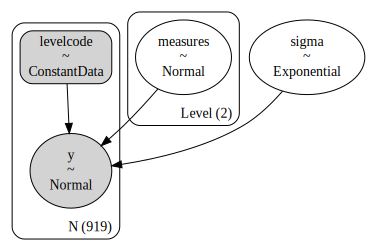

In [22]:
name = 'complete.gv'
dag.exc(model=complete, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

<span style='color: #7f7f00'><b>Test Model</b>: A different set-up, but the same model</span>

In [23]:
individual = src.models.individual.Individual(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)


likelihood
2022-12-01 20:33:19.552



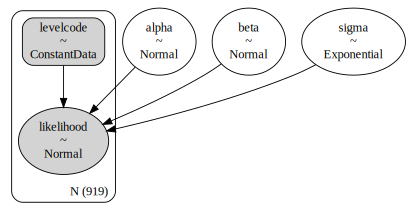

In [24]:
name = 'individual.gv'
dag.exc(model=individual, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

* `inferences.keys()`

* `inferences.get('prior').keys()`


In [25]:
complete_ = src.models.inference.Inference(model=complete).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 20:33:43.587

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 20:33:43.589

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 20:33:47.097

NUTS: [measures, sigma]

NUTS: [measures, sigma]
2022-12-01 20:33:47.098



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
2022-12-01 20:34:17.819

Sampling: [measures, sigma, y]

Sampling: [measures, sigma, y]
2022-12-01 20:34:24.031

Sampling: [y]

Sampling: [y]
2022-12-01 20:34:24.191



In [26]:
complete_ = src.models.mapping.Mapping(inferences=complete_, coords=coords).exc()

In [27]:
complete_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

<span style='color: #7f7f00'><b>Test Model</b>: Inference</span>

In [28]:
individual_ = src.models.inference.Inference(model=individual).exc()

Auto-assigning NUTS sampler...

Auto-assigning NUTS sampler...
2022-12-01 20:34:52.902

Initializing NUTS using jitter+adapt_diag...

Initializing NUTS using jitter+adapt_diag...
2022-12-01 20:34:52.903

Multiprocess sampling (4 chains in 4 jobs)

Multiprocess sampling (4 chains in 4 jobs)
2022-12-01 20:34:56.362

NUTS: [alpha, beta, sigma]

NUTS: [alpha, beta, sigma]
2022-12-01 20:34:56.364



Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
2022-12-01 20:35:28.496

Sampling: [alpha, beta, likelihood, sigma]

Sampling: [alpha, beta, likelihood, sigma]
2022-12-01 20:35:34.881

Sampling: [likelihood]

Sampling: [likelihood]
2022-12-01 20:35:35.071



In [29]:
individual_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>

$\Longrightarrow$

In [30]:
individual_.posterior = individual_.posterior.assign_coords(Level=list(coords['Level'].keys()))

In [31]:
individual_ = src.models.mapping.Mapping(inferences=individual_, coords=coords).exc()

In [32]:
individual_

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

<br>
<br>

### Prior Measures

<br>

**Prior Measures: Distributions**



In [ ]:
computations = []

for k, v in coords['Level'].items():
    
    points = complete_.prior['measures'].sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.head())

<br>

The graph

In [ ]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

### Prior Predictive

In [ ]:
complete_.prior_predictive

<br>
<br>

### Posterior Measures


Notes/references:

* [About `arviz.hdi(.)`](https://arviz-devs.github.io/arviz/api/generated/arviz.hdi.html)

* [About `xarray.DataArray`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray)

* [xarray.DataArray.groupy](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html#xarray.DataArray.groupby)

* cf. `trace.constant_data['level']` & `trace.constant_data['N']`


<br>

**Posterior Measures: Distributions**

In [ ]:
computations = []

for k, v in coords['Level'].items():
    
    points = complete_.posterior['measures'].mean(dim=('chain')).sel(Level=k).squeeze()
    
    instances = pd.DataFrame(data={'measures': points, 'level': np.repeat(v, points.shape[0]), 'type': np.repeat(k, points.shape[0])})
    
    computations.append(instances)

instances = pd.concat(computations, axis=0, ignore_index=True)

logger.info(instances.tail())

<br>

The distributions

In [ ]:
ax = sketch.figure(width=2.1, height=2.9)
sns.boxplot(data=instances, x='type', y='measures', notch=True, color='k', showcaps=False, ax=ax)
sketch.annotation(ax, Labels(title='', xlabel='level', ylabel='mean(ln(radon))'))

<br>
<br>

**Posterior Measures & Standard Deviations: Summaries**

In [ ]:
az.summary(complete_)

<br>
<br>

**Posterior Measures & Standard Deviations: Graphs**

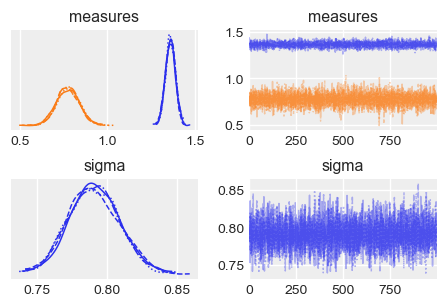

In [33]:
with complete:
    az.plot_trace(data=complete_, figsize=(4.35, 2.95))

<br>

Cf.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000013492820>,
      dtype=object)

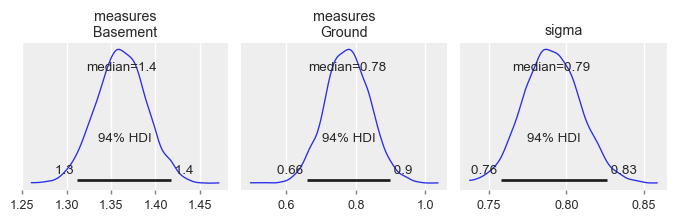

In [37]:
pm.plot_posterior(data=complete_, var_names=['measures', 'sigma'], 
                 figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)

<br>

<span style='color: #7f7f00'><b>Test Model</b></span>

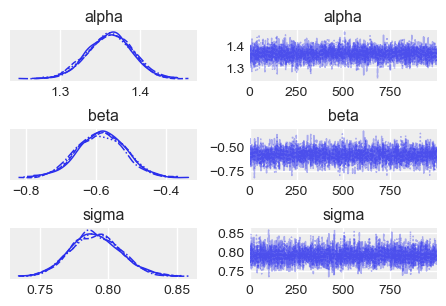

In [34]:
with individual:
    az.plot_trace(data=individual_, figsize=(4.35, 2.95))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000018D00370>,
      dtype=object)

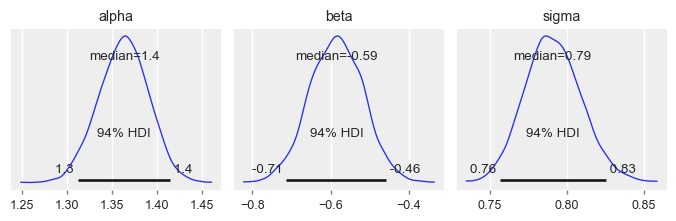

In [41]:
pm.plot_posterior(data=individual_, var_names=['alpha', 'beta', 'sigma'], 
                  figsize=(6.65, 2.1), grid=(1, 3), point_estimate='median', textsize=9)

<br>
<br>

**Posterior Measures Mean**

In [35]:
averages_features = complete_.posterior.mean(dim=('chain', 'draw'))
averages_features

<xarray.Dataset>
Dimensions:    (Level: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    measures   (Level) float64 1.361 0.776
    sigma      float64 0.7908

In [36]:
individual_.posterior.mean(dim=('chain', 'draw'))

<xarray.Dataset>
Dimensions:    (Level: 2, LevelCode: 2)
Coordinates:
  * Level      (Level) <U8 'Basement' 'Ground'
  * LevelCode  (LevelCode) int32 0 1
Data variables:
    alpha      float64 1.362
    beta       float64 -0.5857
    sigma      float64 0.7911

<br>

**Posterior Measures High Density Intervals**

Herein, determining the high density posterior intervals via

> ```python
hdi_features = (
    trace.posterior['measures'].groupby(trace.posterior.LevelName).apply(
        lambda x: az.hdi(x, input_core_dims=[['chain', 'draw']]))['measures']
)
hdi_features


is unnecessarily complex, and the resulting object does not include `LevelCode` co$\ddot{o}$rdinates.

<br>


In [ ]:
hdi_features = az.hdi(complete_)
hdi_features

<br>
<br>

### Posterior Predictive

<br>

**Posterior Predictive Check**

Equivalent:
> ```python 
pm.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

> ```python 
az.plot_ppc(data=..., figsize=(2.9, 2.4), num_pp_samples=125, 
            random_seed=RANDOM_SEED, textsize=10)

<br>

In [ ]:
az.plot_ppc(data=complete_, figsize=(2.9, 2.4), num_pp_samples=125, random_seed=RANDOM_SEED, textsize=10)

<br>
<br>

**The posterior predictive high density interval per floor level type**

In [ ]:
credibility = lambda x: az.hdi(x, input_core_dims=[["chain", "draw", "N"]])
hdi_predictive = (
    complete_.posterior_predictive.y.groupby(complete_.constant_data.levelcode)
    .apply(credibility)
    .y
)
hdi_predictive

<br>

### Graphs

<br>

**High Density Intervals, Averages**

Options:

* `sns.scatterplot(y=complete_.observed_data['y'], x=trace.observed_data['LevelName'], ax=ax)`

In [ ]:
ax = sketch.figure(width=4.25, height=2.7)

complete_.observed_data.plot.scatter(x='LevelCode', y='y', label='Observations', alpha=0.25, ax=ax)

az.plot_hdi(hdi_predictive.levelcode.values, 
            hdi_data=hdi_predictive, 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. distrib. of Radon levels'}, 
            color='k',
            ax=ax)

az.plot_hdi(hdi_features.LevelCode.values, 
            hdi_data=hdi_features['measures'], 
            fill_kwargs={'alpha': 0.25, 'label': 'Exp. mean HPD'}, 
            color='green',
            ax=ax)

ax.plot(np.arange(averages_features.coords['Level'].shape[0]), 
        averages_features['measures'].values, 
        color='orange',
        label='Exp. mean')

sketch.annotation(ax, Labels(title='', xlabel='', ylabel='mean(ln(radon))'))

ax.set_xlim(-0.25, 1.25)

ax.set_xticks(complete_.posterior['LevelCode'].values)
ax.set_xticklabels(complete_.posterior['Level'].values, rotation=0)

ax.legend(fontsize=8, frameon=True, bbox_to_anchor=(1, 1), loc='upper left')

<br>
<br>

**Clean-up**

In [ ]:
del hdi_features, averages_features, hdi_predictive

<br>

### Inference Data

In [ ]:
complete_

<br>
<br>

## Unpooled

<br>

The object `coords` has the set of distinct counties, each has a distinct index; ref. `coords['County']`.  &nbsp; In future use [an appropriate geographic code](https://www.nist.gov/system/files/documents/2021/08/11/FIPSCodesReplacementChart2015.pdf). &nbsp;  Additionally, the data object `excerpt` includes a `countyindex` field, whereby the relevant dictionary is $\rightarrow$ `coords['County']`.

> ```python
logger.info(coords.keys())
logger.info(coords.get('County'))
```


<br>

### Model

In [ ]:
unpooled = src.models.unpooled.Unpooled(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)

<br>
<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(unpooled)`

In [ ]:
name = 'unpooled.gv'
dag.exc(model=unpooled, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [ ]:
unpooled_ = src.models.inference.Inference(model=unpooled).exc()

In [ ]:
unpooled_ = src.models.mapping.Mapping(inferences=unpooled_, coords=coords).exc()

In [ ]:
unpooled_

<br>
<br>

### Posterior Measures

<br>

**Posterior Measures & Standard Deviations: Summaries**

In [ ]:
az.summary(unpooled_)

<br>

<br>

**Posterior Measures & Standard Deviations: Graphs**

In [ ]:
with unpooled:
    az.plot_trace(data=unpooled_, figsize=(4.35, 2.95))

<br>
<br>

**Posterior Measures: High Density Intervals**

In [ ]:
az.plot_forest(
    unpooled_, var_names='measures', figsize=(6, 32), r_hat=True, combined=True, textsize=8
);

<br>

**Posterior Mean**

In [ ]:
averages_features = unpooled_.posterior.mean(dim=('chain', 'draw'))
averages_features

<br>

**Posterior Check**

In [ ]:
hdi_features = az.hdi(unpooled_)
hdi_features

<br>
<br>

### Graphs

<br>

**High Density Intervals, Averages**

For more about `sel(.)` visit [arviz.InferenceData.sel(.)](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.sel.html).  &nbsp; The # of counties is

> ```python 
len(coords.get('County'))


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.7))

xticks = np.arange(0, 86, 6)

fontdict = {'horizontalalignment': 'right', 'fontsize': 8}

for ax, level in zip(axes, ['Basement', 'Ground']):
    
    averages_ = averages_features.sel(Level=level).sortby('measures')
    
    # the HDI limits per County ordered by increasing average, i.e., as above
    hdi_ = hdi_features.sel(Level=level).sortby(averages_.measures)
    
    # the scatter plot of the average value per County
    ax.plot(averages_['County'].values, averages_['measures'].values, 'ok', markersize=3, alpha=0.5);
    
    # high density interval lines
    ax.vlines(
        np.arange(len(coords.get('County'))),
        hdi_.measures.sel(hdi='lower'),
        hdi_.measures.sel(hdi='higher'),
        color='orange',
        alpha=0.6,
    )    
    
    # titles
    ax.set_title(f'\n{level.title()} estimates\n', fontsize=11)
    
    # x ticks
    ax.set_xticks(xticks)
    ax.set_xticklabels(averages_.County.values[xticks], horizontalalignment='right', rotation=45)
    
    # all ticks
    ax.tick_params(labelsize='x-small')
    
    # limits
    ax.set_ylim(bottom=-2, top=4.5)
    
    # labels
    ax.set_xlabel('County', fontsize=10)
    ax.set_ylabel('Radon estimate', fontsize=10)
    

<br>
<br>

**Ground Level Dispersions of High Density Intervals**

Ground level posterior `measures`  high density interval data

In [ ]:
experiment = hdi_features['measures'].sel(Level='Ground')

<br>

Hence, the differences and their parallel county names

In [ ]:
differences = pd.DataFrame(data={'difference': experiment.sel(hdi='higher') - experiment.sel(hdi='lower'), 
                                 'county': experiment['County']})

<br>

Differences and frequencies.

In [ ]:
values = frequencies.loc[frequencies['floor'] == coords['Level']['Ground'], ]
dispersions = differences.merge(values, how='left', on='county')
logger.info(dispersions.tail())

<br>

Some counties do not have any ground level data points

In [ ]:
dispersions.loc[:, 'N'] = dispersions['N'].fillna(value=0).array
logger.info(dispersions.tail())

<br>

The graph below illustrates that the large dispersions, intervals, are due counties that do not have data points.

In [ ]:
ax = sketch.figure(width=5.7, height=2.3)

ax.plot(dispersions['N'].array, dispersions['difference'].array, 'ok', markersize=3, alpha=0.5, label='dispersion points');
sketch.annotation(ax, Labels(title='', xlabel='N', ylabel='dispersion'))
ax.legend(loc='upper right', fontsize='small');

<br>
<br>

**Funnel**

Upcoming

<br>
<br>

**Estimates**

Upcoming

In [ ]:
averages_features['measures'].sel(County='AITKIN')

In [ ]:
unpooled_.observed_data['y'][unpooled_.observed_data.coords['County'] == 'AITKIN']

<br>
<br>

**Clean-up**

In [ ]:
del hdi_features, hdi_, averages_features, averages_

<br>
<br>

### Inference Data

In [ ]:
unpooled_

<br>
<br>
<br>

## Partial

### Model

In [ ]:
partial = src.models.partial.Partial(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)

<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(partial)`

In [ ]:
name = 'partial.gv'
dag.exc(model=partial, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [ ]:
partial_ = src.models.inference.Inference(model=partial).exc()

In [ ]:
partial_

<br>

Enrich

In [ ]:
partial_ = src.models.mapping.Mapping(inferences=partial_, coords=coords).exc()

In [ ]:
partial_

<br>
<br>

### Posterior Measures

<br>

**Preliminaries**

The frequencies

In [ ]:
logger.info(frequencies.head())

<br>

Tallies by county only.

In [ ]:
T = frequencies.groupby(by=['county', 'countyindex']).agg(N=('N', sum))
T.reset_index(drop=False, inplace=True)
K = T.copy().set_index(keys='countyindex')

logger.info(T.tail())
logger.info(K.tail())

<br>

Extra co${\ddot{o}}$rdinates



> ```python 
indices[-5:]


In [ ]:
indices = partial_.posterior.coords['CountyIndex'].values

In [ ]:
partial_.posterior = partial_.posterior.assign_coords({'Tally': ('County', K.iloc[indices, :]['N'].array)})

In [ ]:
partial_

<br>

**Posterior Mean**

In [ ]:
averages_features = partial_.posterior.mean(dim=('chain', 'draw'))
averages_features

<br>

**Posterior Check**

In [ ]:
hdi_features = az.hdi(partial_)
hdi_features

<br>
<br>

### Graphs

<br>

**High Density Intervals, Averages,Tallies**

County tally, posterior mean, and high density interval.  `Either`

In [ ]:
ax = sketch.figure(width=4.1, height=2.5)

# scatter plot
ax.plot(averages_features.coords['Tally'].values, averages_features['intercepts'].values, 'ok', markersize=3, alpha=0.5);

# high density interval lines
ax.vlines(
    hdi_features.coords['Tally'].values,
    hdi_features['intercepts'].sel(hdi='lower').values,
    hdi_features['intercepts'].sel(hdi='higher').values,
    color='orange',
    linestyles='dashed',
    alpha=0.6,
)

# logarithmic scale
ax.set(xscale='log')

# annotations
sketch.annotation(ax, Labels(title='', xlabel='ln(# of county observations)', ylabel='mean(ln(radon))'))

<br>

`Or`

In [ ]:
ax = sketch.figure(width=4.1, height=2.5)

# limits
X = np.concatenate((np.expand_dims(hdi_features['intercepts'].sel(hdi='lower').values, axis=0),
                    np.expand_dims(hdi_features['intercepts'].sel(hdi='higher').values, axis=0)))

points = averages_features['intercepts'].values
Y = np.concatenate((np.expand_dims(points - hdi_features['intercepts'].sel(hdi='lower').values, axis=0),
                    np.expand_dims(hdi_features['intercepts'].sel(hdi='higher').values - points, axis=0)))

# graph
ax.errorbar(averages_features.coords['Tally'].values, 
            averages_features['intercepts'].values, 
            Y, 
            uplims=True, lolims=True,
            ecolor='orange', 
            marker='o', markersize=3, markerfacecolor='k', markeredgecolor='k', 
            linestyle='',
            alpha=0.5)

# logarithmic scale
ax.set(xscale='log')

# annotations
sketch.annotation(ax, Labels(title='', xlabel='ln(# of county observations)', ylabel='mean(ln(radon))'))

<br>
<br>

**Clean-up**

In [ ]:
del X, Y, hdi_features, averages_features

<br>
<br>

### Inference Data

In [ ]:
partial_

<br>
<br>
<br>

## Varying Intercept

### Model

In [ ]:
vi = src.models.vi.VI(coords=coords, seed=RANDOM_SEED).exc(data=excerpt)

<br>

An illustration of model

* Similarly: `pm.model_to_graphviz(vi)`

In [ ]:
name = 'vi.gv'
dag.exc(model=vi, name=name)
graphviz.Source.from_file(filename=os.path.join(path, name))

<br>
<br>

### Inference

In [ ]:
vi_ = src.models.inference.Inference(model=vi).exc()

In [ ]:
vi_